# Liquid Clustering Notebook

This notebook performs the following operations:

- Create Delta Lake tables with liquid clustering configuration
- Insert data into the table
- Display table properties
- Run optimization operations
- Run queries
- Display query execution time

In [11]:
spark.stop()

In [1]:
from pyspark.sql import SparkSession
import os

spark = SparkSession.builder \
    .appName("Clustering") \
    .master("spark://192.168.0.144:7077") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
    .config("spark.hadoop.hive.metastore.uris", "thrift://192.168.0.144:9083") \
    .config("spark.hadoop.javax.jdo.option.ConnectionURL", "jdbc:mysql://192.168.0.144:3306/metastore_db") \
    .config("spark.hadoop.javax.jdo.option.ConnectionDriverName", "com.mysql.cj.jdbc.Driver") \
    .config("spark.hadoop.javax.jdo.option.ConnectionUserName", "lh") \
    .config("spark.hadoop.javax.jdo.option.ConnectionPassword", os.getenv('MYSQL', 'Default_Value')) \
    .config("spark.jars", "/usr/local/spark/jars/delta-storage-3.2.0.jar,/usr/local/spark/jars/delta-spark_2.12-3.2.0.jar")    \
    .config("spark.delta.logStore.class", "org.apache.spark.sql.delta.storage.HDFSLogStore") \
    .config("spark.executor.memory", "9g") \
    .config("spark.executor.cores", "3") \
    .config("spark.driver.memory", "19g") \
    .config("spark.driver.maxResultSize", "2g") \
    .config("spark.hadoop.fs.defaultFS", "hdfs://192.168.0.144:9000") \
    .config("spark.databricks.delta.clusteredTable.enableClusteringTablePreview", "true") \
    .config("spark.sql.debug.maxToStringFields", "1000") \
    .enableHiveSupport() \
    .getOrCreate()


24/08/07 07:48:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
db='liquidclustering'
delta_db_path = 'hdfs://192.168.0.144:9000/datalake/liquidclustering'

In [3]:
#spark.sql(f"DROP DATABASE {db} CASCADE")
#spark.sql(f"CREATE DATABASE {db} LOCATION '{delta_db_path}'")
spark.sql(f"use database {db}")

DataFrame[]

In [4]:
spark.sql(f"show tables").show(truncate=False)

+----------------+----------------------------------+-----------+
|namespace       |tableName                         |isTemporary|
+----------------+----------------------------------+-----------+
|liquidclustering|campaign_dim                      |false      |
|liquidclustering|clustering_eventid_actorid_table_2|false      |
|liquidclustering|clustering_eventid_actorid_table_4|false      |
|liquidclustering|clustering_eventid_actorid_table_8|false      |
|liquidclustering|customer_dim                      |false      |
|liquidclustering|department_dim                    |false      |
|liquidclustering|location_dim                      |false      |
|liquidclustering|product_dim                       |false      |
+----------------+----------------------------------+-----------+


In [9]:
import subprocess
import matplotlib.pyplot as plt
import random
from pyspark.sql.functions import lit, rand, expr, year, month, dayofmonth, concat, lpad, element_at, array
from pyspark.sql.types import StringType, StructType, StructField, DateType, TimestampType, DoubleType, LongType, IntegerType
from pyspark.sql import SparkSession
from datetime import datetime, timedelta
import itertools
import random
from pyspark.sql.functions import lit, rand, udf, col, expr, year, month, dayofmonth, concat, lpad
from pyspark.sql.types import StringType

spark.sql("USE liquidclustering")

# Parameters
num_pairs = 3  # Number of table pairs to create
max_rows = 8  # Maximum number of rows for the largest table 8000000000

row_counts = [max_rows // (2 ** i) for i in range(num_pairs)]


"""
Create and initialize a specified number of Delta Lake tables with liquid clustering.
Each table is dropped if it exists and then recreated with the specified schema.
"""
for i in range(num_pairs):
    cluster_table_name = f"clustering_eventid_actorid_table_{row_counts[i]}"
    
    spark.sql(f"DROP TABLE IF EXISTS {cluster_table_name}")

    
    spark.sql(f"""
    CREATE TABLE {cluster_table_name} (
        timestamp TIMESTAMP,
        value DOUBLE,
        country STRING,
        event_id LONG,
        actor_id LONG,
        year INT,
        month LONG,
        day LONG,
        product_id INT,          
        location_id INT,         
        department_id INT,      
        campaign_id INT,         
        customer_id INT        
    )
    USING delta
    CLUSTER  BY (event_id, actor_id);
    """)

24/07/29 17:13:47 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`liquidclustering`.`clustering_eventid_actorid_table_8` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 17:13:47 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/07/29 17:13:49 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`liquidclustering`.`clustering_eventid_actorid_table_4` into Hive metastore in Spark SQL specific format, which is NOT compatible with Hive.
24/07/29 17:13:52 WARN HiveExternalCatalog: Couldn't find corresponding Hive SerDe for data source provider delta. Persisting data source table `spark_catalog`.`liquidclustering`.`clustering_eventid_actorid_table_2` into Hive metastore

In [13]:
spark.sql("show tables").show(truncate=False)

+----------------+----------------------------------+-----------+
|namespace       |tableName                         |isTemporary|
+----------------+----------------------------------+-----------+
|liquidclustering|campaign_dim                      |false      |
|liquidclustering|clustering_eventid_actorid_table_2|false      |
|liquidclustering|clustering_eventid_actorid_table_4|false      |
|liquidclustering|clustering_eventid_actorid_table_8|false      |
|liquidclustering|customer_dim                      |false      |
|liquidclustering|department_dim                    |false      |
|liquidclustering|location_dim                      |false      |
|liquidclustering|product_dim                       |false      |
+----------------+----------------------------------+-----------+


In [14]:
table_pairs = [
    ('liquidclustering.clustering_eventid_actorid_table_8', 'raw_data.raw_data_8'),
    ('liquidclustering.clustering_eventid_actorid_table_4', 'raw_data.raw_data_4'),
    ('liquidclustering.clustering_eventid_actorid_table_2', 'raw_data.raw_data_2')
]

for target_table, source_table in table_pairs:
    insert_sql = f"""
    INSERT INTO {target_table}
    SELECT * FROM {source_table}
    """
    print(f"Inserting data for table {target_table}")
    %time spark.sql(insert_sql)

Inserting data for table liquidclustering.clustering_eventid_actorid_table_8


CPU times: user 1.96 s, sys: 1.8 s, total: 3.76 s
Wall time: 1h 34min 27s
Inserting data for table liquidclustering.clustering_eventid_actorid_table_4


CPU times: user 1.05 s, sys: 621 ms, total: 1.67 s
Wall time: 52min 36s
Inserting data for table liquidclustering.clustering_eventid_actorid_table_2


CPU times: user 525 ms, sys: 360 ms, total: 884 ms
Wall time: 25min 45s


In [4]:
from delta.tables import DeltaTable

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_8",
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_4",
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_2"
]

for path in table_paths:
    delta_table_obj = DeltaTable.forPath(spark, path)
    
    table_name = path.split("/")[-1]
    print(f"Optimizing and compacting table: {table_name}")
    
    %time delta_table_obj.optimize().executeCompaction()


Optimizing and compacting table: clustering_eventid_actorid_table_8


24/07/30 20:50:32 ERROR TaskSchedulerImpl: Lost executor 5 on 192.168.0.146: worker lost: Not receiving heartbeat for 60 seconds
24/07/30 20:50:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_24_13 !
24/07/30 20:50:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_24_21 !
24/07/30 20:50:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_14_13 !
24/07/30 20:50:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_24_17 !
24/07/30 20:50:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_14_17 !
24/07/30 20:50:32 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_14_21 !
24/07/30 21:05:59 WARN TransportChannelHandler: Exception in connection from /192.168.0.146:54040
java.io.IOException: No route to host
	at sun.nio.ch.FileDispatcherImpl.read0(Native Method)
	at sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:39)
	at sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.jav

CPU times: user 7 s, sys: 11 s, total: 18 s
Wall time: 4h 21min 41s
Optimizing and compacting table: clustering_eventid_actorid_table_4


CPU times: user 3.89 s, sys: 3.57 s, total: 7.46 s
Wall time: 2h 31min 10s
Optimizing and compacting table: clustering_eventid_actorid_table_2


CPU times: user 1.92 s, sys: 2.01 s, total: 3.93 s
Wall time: 1h 19min 33s


In [8]:
from delta.tables import DeltaTable

spark.conf.set("spark.databricks.delta.retentionDurationCheck.enabled", "false")

table_paths = [
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_8",
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_4",
    "hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_2"
]


for path in table_paths:
    print(f"Deleting unused files for table {path}")
    delta_table_obj = DeltaTable.forPath(spark, path)
    %time delta_table_obj.vacuum(0)


Deleting unused files for table hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_8


Deleted 1293 files and directories in a total of 1 directories.
CPU times: user 0 ns, sys: 186 ms, total: 186 ms
Wall time: 30.7 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_4


Deleted 647 files and directories in a total of 1 directories.
CPU times: user 23.3 ms, sys: 92.3 ms, total: 116 ms
Wall time: 19.3 s
Deleting unused files for table hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_2


Deleted 330 files and directories in a total of 1 directories.
CPU times: user 0 ns, sys: 132 ms, total: 132 ms
Wall time: 17.1 s


In [6]:
# Display table properties

import subprocess
import matplotlib.pyplot as plt
import os

def display_table_properties(spark, database, tables):
    # Set Hadoop environment variables
    os.environ['HADOOP_HOME'] = '/usr/local/hadoop'
    os.environ['PATH'] = os.environ['PATH'] + ':' + os.environ['HADOOP_HOME'] + '/bin'

    spark.sql(f"USE {database}")

    table_details = []

    for table_name in tables:
        describe_df = spark.sql(f"DESCRIBE DETAIL {table_name}")
        describe_detail = describe_df.collect()[0].asDict()
        hdfs_location = describe_detail['location']
        num_files = describe_detail['numFiles']
        partition_columns = describe_detail['partitionColumns']

        result = subprocess.run(["hdfs", "dfs", "-du", "-s", hdfs_location], capture_output=True, text=True)
        size = int(result.stdout.split()[0])

        count_result = subprocess.run(["hdfs", "dfs", "-count", hdfs_location], capture_output=True, text=True)
        subdirectories = int(count_result.stdout.split()[0]) - 1  

        row_count_df = spark.sql(f"SELECT COUNT(*) AS row_count FROM {table_name}")
        row_count = row_count_df.collect()[0]['row_count']

        table_details.append((table_name, hdfs_location, size, num_files, partition_columns, subdirectories, row_count))

    for table in table_details:
        print(f"Table: {table[0]}, HDFS Directory: {table[1]}, Size: {table[2]} bytes, Number of Files: {table[3]}, Partition Columns: {table[4]}, Subdirectories: {table[5]}, Number of Rows: {table[6]}")

    # Extract data for plotting
    table_names = [table[0] for table in table_details]
    sizes = [table[2] / (1024 ** 3) for table in table_details] 
    num_files = [table[3] for table in table_details]
    subdirectories = [table[5] for table in table_details]
    row_counts = [table[6] for table in table_details]

    fig, axs = plt.subplots(4, 1, figsize=(10, 14))

    axs[0].bar(table_names, sizes, color='b')
    axs[0].set_title('Table Sizes')
    axs[0].set_ylabel('Size (GB)')
    axs[0].tick_params(axis='x', rotation=45)

    axs[1].bar(table_names, num_files, color='g')
    axs[1].set_title('Number of Files')
    axs[1].set_ylabel('Files')
    axs[1].tick_params(axis='x', rotation=45)

    axs[2].bar(table_names, subdirectories, color='r')
    axs[2].set_title('Number of Subdirectories')
    axs[2].set_ylabel('Subdirectories')
    axs[2].tick_params(axis='x', rotation=45)

    axs[3].bar(table_names, row_counts, color='c')
    axs[3].set_title('Number of Rows')
    axs[3].set_ylabel('Rows')
    axs[3].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


Table: clustering_eventid_actorid_table_2, HDFS Directory: hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_2, Size: 48108057467 bytes, Number of Files: 40, Partition Columns: [], Subdirectories: 2, Number of Rows: 2000000000
Table: clustering_eventid_actorid_table_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_4, Size: 96272046615 bytes, Number of Files: 80, Partition Columns: [], Subdirectories: 2, Number of Rows: 4000000000
Table: clustering_eventid_actorid_table_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/liquidclustering/clustering_eventid_actorid_table_8, Size: 191859851555 bytes, Number of Files: 160, Partition Columns: [], Subdirectories: 2, Number of Rows: 8000000000


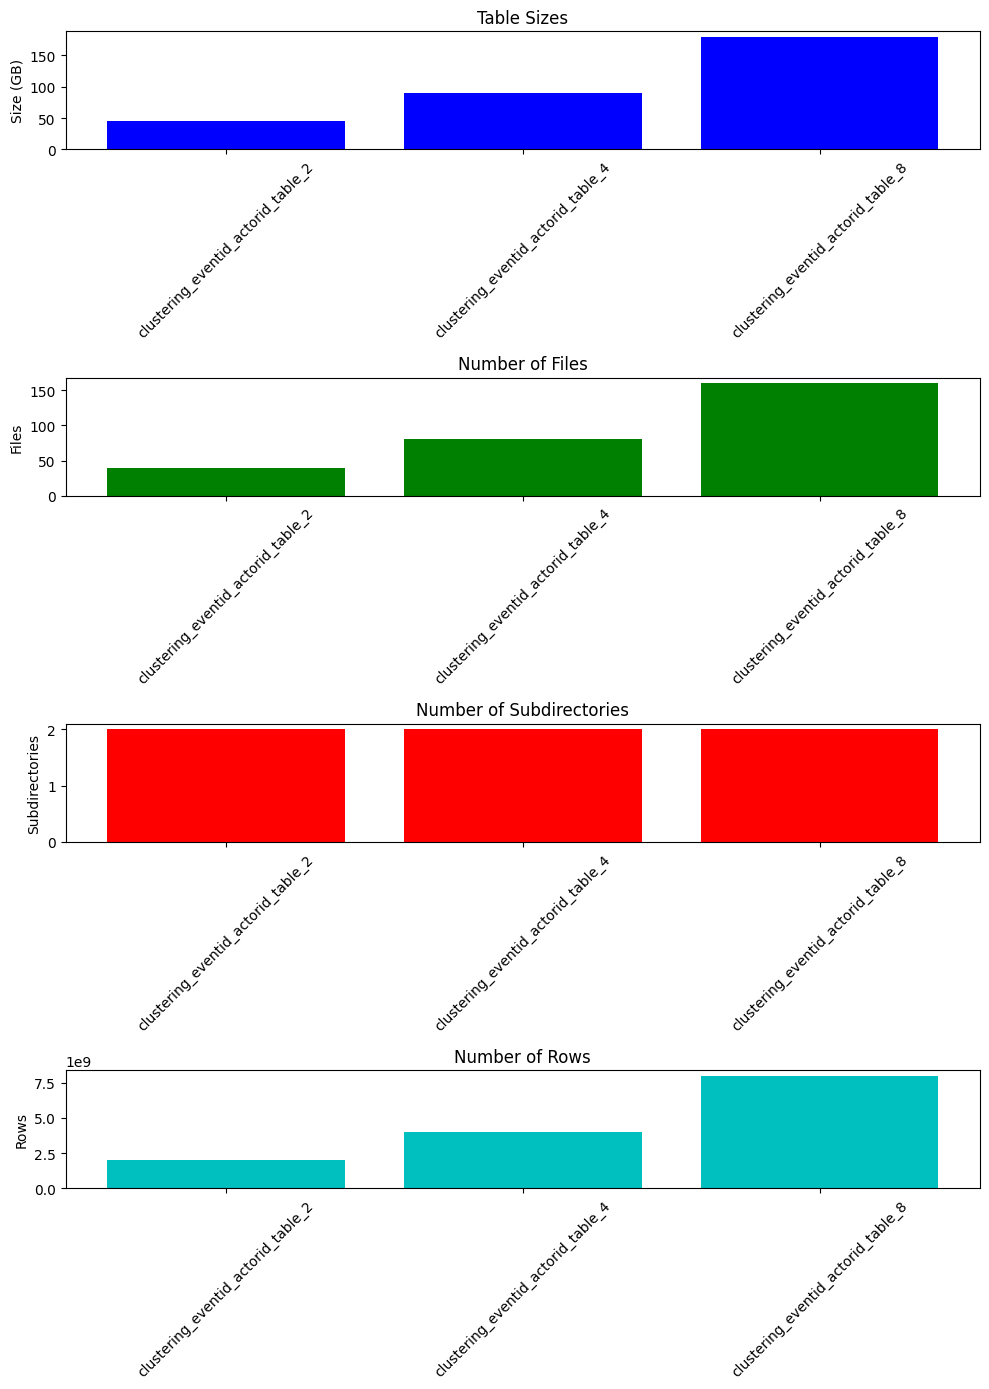

In [9]:
display_table_properties(spark, "liquidclustering", ['clustering_eventid_actorid_table_2', 'clustering_eventid_actorid_table_4', 'clustering_eventid_actorid_table_8'])

Table: raw_data_2, HDFS Directory: hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_2, Size: 43359013259 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 2000000000
Table: raw_data_4, HDFS Directory: hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_4, Size: 86718037909 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 4000000000
Table: raw_data_8, HDFS Directory: hdfs://192.168.0.144:9000/datalake/raw_data/raw_data_8, Size: 173433056152 bytes, Number of Files: 15, Partition Columns: [], Subdirectories: 2, Number of Rows: 8000000000


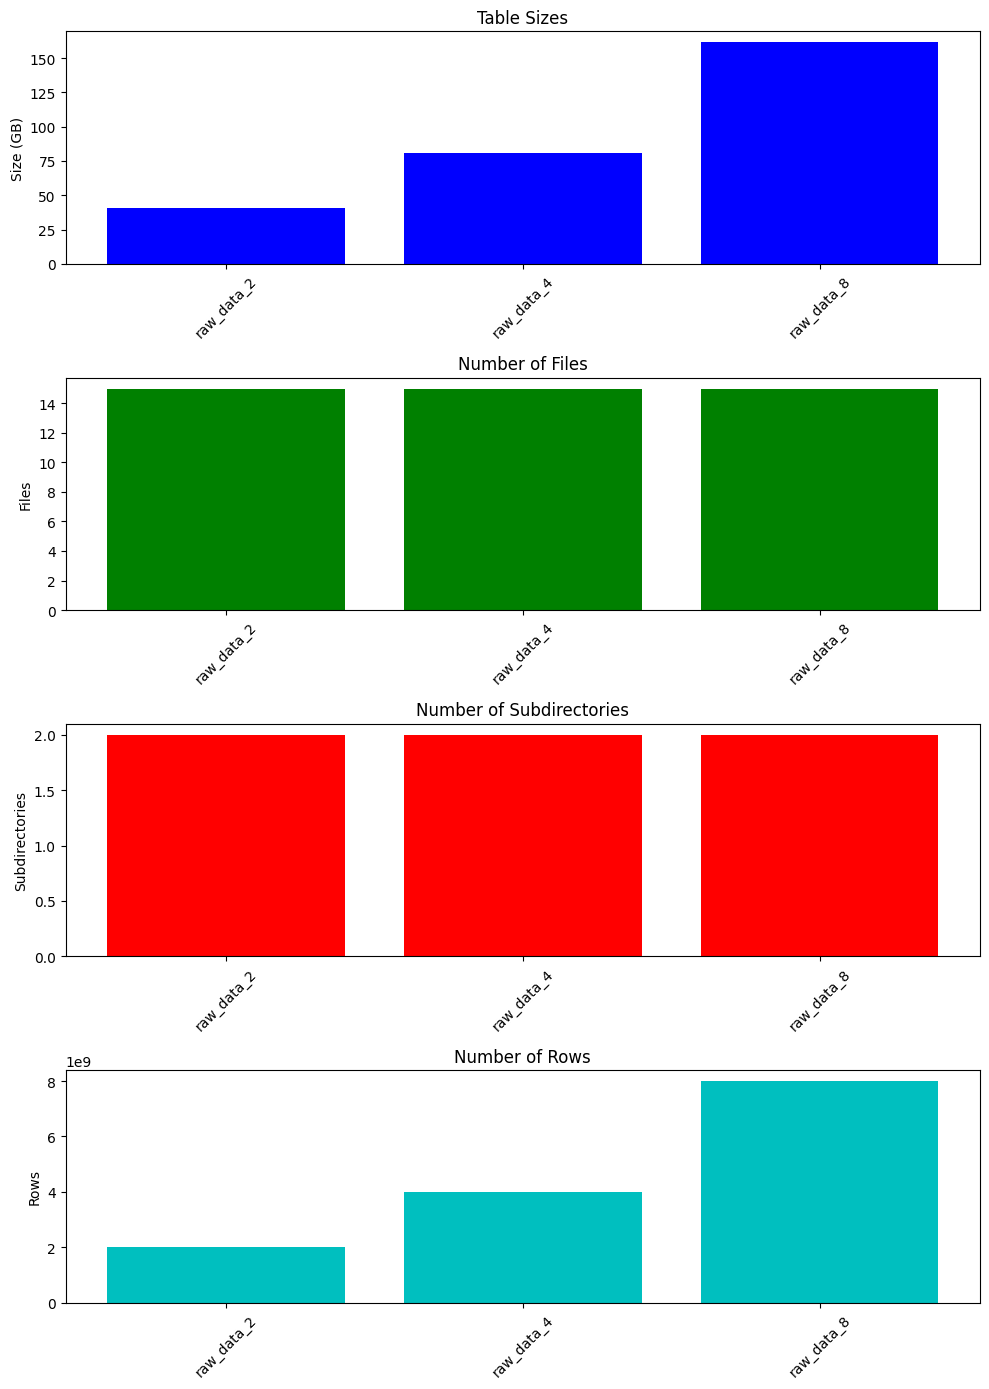

In [10]:
display_table_properties(spark, "raw_data", ['raw_data_2', 'raw_data_4', 'raw_data_8'])

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA| 16396.40482525763|      32668|
|   Product F|Philadelphia|   PA|    USA| 16363.65236687837|      32630|
|   Product I|      Dallas|   TX|    USA|16242.105290648453|      32567|
|   Product G| San Antonio|   TX|    USA|16201.450733896252|      32234|
|   Product D|     Houston|   TX|    USA|16158.383915127806|      32313|
|   Product E|     Phoenix|   AZ|    USA| 16119.03607842406|      32304|
|   Product J|    San Jose|   CA|    USA|16118.795541590378|      32264|
|   Product C|     Chicago|   IL|    USA|16108.411614653278|      32346|
|   Product B| Los Angeles|   CA|    USA|16057.591442222523|      32257|
|   Product H|   San Diego|   CA|    USA|15985.868776843714|      31980|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|16396.404825257625|      32668|
|   Product F|Philadelphia|   PA|    USA|16363.652366878368|      32630|
|   Product I|      Dallas|   TX|    USA| 16242.10529064845|      32567|
|   Product G| San Antonio|   TX|    USA|16201.450733896254|      32234|
|   Product D|     Houston|   TX|    USA|16158.383915127806|      32313|
|   Product E|     Phoenix|   AZ|    USA|16119.036078424053|      32304|
|   Product J|    San Jose|   CA|    USA|16118.795541590376|      32264|
|   Product C|     Chicago|   IL|    USA|16108.411614653274|      32346|
|   Product B| Los Angeles|   CA|    USA|16057.591442222527|      32257|
|   Product H|   San Diego|   CA|    USA|15985.868776843716|      31980|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|16396.404825257625|      32668|
|   Product F|Philadelphia|   PA|    USA|16363.652366878368|      32630|
|   Product I|      Dallas|   TX|    USA|16242.105290648451|      32567|
|   Product G| San Antonio|   TX|    USA|16201.450733896252|      32234|
|   Product D|     Houston|   TX|    USA|16158.383915127806|      32313|
|   Product E|     Phoenix|   AZ|    USA|16119.036078424053|      32304|
|   Product J|    San Jose|   CA|    USA|16118.795541590378|      32264|
|   Product C|     Chicago|   IL|    USA|16108.411614653274|      32346|
|   Product B| Los Angeles|   CA|    USA|16057.591442222527|      32257|
|   Product H|   San Diego|   CA|    USA|15985.868776843714|      31980|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|16396.404825257625|      32668|
|   Product F|Philadelphia|   PA|    USA|16363.652366878367|      32630|
|   Product I|      Dallas|   TX|    USA| 16242.10529064845|      32567|
|   Product G| San Antonio|   TX|    USA|16201.450733896256|      32234|
|   Product D|     Houston|   TX|    USA|16158.383915127804|      32313|
|   Product E|     Phoenix|   AZ|    USA|16119.036078424057|      32304|
|   Product J|    San Jose|   CA|    USA|16118.795541590378|      32264|
|   Product C|     Chicago|   IL|    USA|16108.411614653274|      32346|
|   Product B| Los Angeles|   CA|    USA|16057.591442222527|      32257|
|   Product H|   San Diego|   CA|    USA|15985.868776843716|      31980|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product A|    New York|   NY|    USA|16396.404825257625|      32668|
|   Product F|Philadelphia|   PA|    USA|16363.652366878365|      32630|
|   Product I|      Dallas|   TX|    USA| 16242.10529064845|      32567|
|   Product G| San Antonio|   TX|    USA|16201.450733896254|      32234|
|   Product D|     Houston|   TX|    USA| 16158.38391512781|      32313|
|   Product E|     Phoenix|   AZ|    USA|16119.036078424055|      32304|
|   Product J|    San Jose|   CA|    USA|16118.795541590378|      32264|
|   Product C|     Chicago|   IL|    USA|16108.411614653274|      32346|
|   Product B| Los Angeles|   CA|    USA|16057.591442222527|      32257|
|   Product H|   San Diego|   CA|    USA|15985.868776843714|      31980|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product F|Philadelphia|   PA|    USA|  32617.2974735707|      64999|
|   Product E|     Phoenix|   AZ|    USA|32538.729712205997|      64993|
|   Product H|   San Diego|   CA|    USA|32535.895452300505|      65026|
|   Product B| Los Angeles|   CA|    USA|32480.999264516166|      64962|
|   Product G| San Antonio|   TX|    USA|32392.873416005263|      64692|
|   Product I|      Dallas|   TX|    USA| 32388.78168043151|      64797|
|   Product J|    San Jose|   CA|    USA| 32356.03622827908|      64619|
|   Product A|    New York|   NY|    USA|32269.700898669955|      64515|
|   Product D|     Houston|   TX|    USA| 32261.90412464029|      64540|
|   Product C|     Chicago|   IL|    USA| 32251.42279999095|      64692|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product F|Philadelphia|   PA|    USA|32617.297473570696|      64999|
|   Product E|     Phoenix|   AZ|    USA|32538.729712205997|      64993|
|   Product H|   San Diego|   CA|    USA| 32535.89545230051|      65026|
|   Product B| Los Angeles|   CA|    USA|32480.999264516166|      64962|
|   Product G| San Antonio|   TX|    USA| 32392.87341600526|      64692|
|   Product I|      Dallas|   TX|    USA|32388.781680431523|      64797|
|   Product J|    San Jose|   CA|    USA|32356.036228279085|      64619|
|   Product A|    New York|   NY|    USA|32269.700898669962|      64515|
|   Product D|     Houston|   TX|    USA|32261.904124640285|      64540|
|   Product C|     Chicago|   IL|    USA| 32251.42279999095|      64692|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product F|Philadelphia|   PA|    USA|32617.297473570685|      64999|
|   Product E|     Phoenix|   AZ|    USA|   32538.729712206|      64993|
|   Product H|   San Diego|   CA|    USA|32535.895452300505|      65026|
|   Product B| Los Angeles|   CA|    USA|32480.999264516166|      64962|
|   Product G| San Antonio|   TX|    USA|32392.873416005255|      64692|
|   Product I|      Dallas|   TX|    USA|32388.781680431515|      64797|
|   Product J|    San Jose|   CA|    USA| 32356.03622827909|      64619|
|   Product A|    New York|   NY|    USA|32269.700898669962|      64515|
|   Product D|     Houston|   TX|    USA|32261.904124640278|      64540|
|   Product C|     Chicago|   IL|    USA|32251.422799990953|      64692|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product F|Philadelphia|   PA|    USA|32617.297473570703|      64999|
|   Product E|     Phoenix|   AZ|    USA|32538.729712206004|      64993|
|   Product H|   San Diego|   CA|    USA|32535.895452300512|      65026|
|   Product B| Los Angeles|   CA|    USA| 32480.99926451617|      64962|
|   Product G| San Antonio|   TX|    USA| 32392.87341600526|      64692|
|   Product I|      Dallas|   TX|    USA|32388.781680431523|      64797|
|   Product J|    San Jose|   CA|    USA|32356.036228279085|      64619|
|   Product A|    New York|   NY|    USA| 32269.70089866996|      64515|
|   Product D|     Houston|   TX|    USA| 32261.90412464028|      64540|
|   Product C|     Chicago|   IL|    USA| 32251.42279999095|      64692|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product F|Philadelphia|   PA|    USA|  32617.2974735707|      64999|
|   Product E|     Phoenix|   AZ|    USA|   32538.729712206|      64993|
|   Product H|   San Diego|   CA|    USA|  32535.8954523005|      65026|
|   Product B| Los Angeles|   CA|    USA| 32480.99926451617|      64962|
|   Product G| San Antonio|   TX|    USA|32392.873416005255|      64692|
|   Product I|      Dallas|   TX|    USA| 32388.78168043151|      64797|
|   Product J|    San Jose|   CA|    USA| 32356.03622827909|      64619|
|   Product A|    New York|   NY|    USA|32269.700898669962|      64515|
|   Product D|     Houston|   TX|    USA|32261.904124640292|      64540|
|   Product C|     Chicago|   IL|    USA|32251.422799990945|      64692|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 65191.51898022234|     130078|
|   Product I|      Dallas|   TX|    USA| 65185.62197452655|     130195|
|   Product H|   San Diego|   CA|    USA| 65083.52279074958|     130341|
|   Product B| Los Angeles|   CA|    USA| 64860.42439826131|     130214|
|   Product F|Philadelphia|   PA|    USA| 64772.35912565876|     129080|
|   Product D|     Houston|   TX|    USA|64746.426845659174|     129525|
|   Product J|    San Jose|   CA|    USA| 64680.13073277158|     129315|
|   Product E|     Phoenix|   AZ|    USA|64666.843847640324|     129514|
|   Product C|     Chicago|   IL|    USA|64644.877223910284|     129315|
|   Product A|    New York|   NY|    USA| 64565.91029351369|     128976|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 65191.51898022235|     130078|
|   Product I|      Dallas|   TX|    USA| 65185.62197452653|     130195|
|   Product H|   San Diego|   CA|    USA| 65083.52279074957|     130341|
|   Product B| Los Angeles|   CA|    USA| 64860.42439826129|     130214|
|   Product F|Philadelphia|   PA|    USA|  64772.3591256588|     129080|
|   Product D|     Houston|   TX|    USA| 64746.42684565917|     129525|
|   Product J|    San Jose|   CA|    USA| 64680.13073277159|     129315|
|   Product E|     Phoenix|   AZ|    USA| 64666.84384764035|     129514|
|   Product C|     Chicago|   IL|    USA| 64644.87722391031|     129315|
|   Product A|    New York|   NY|    USA|64565.910293513676|     128976|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|65191.518980222325|     130078|
|   Product I|      Dallas|   TX|    USA| 65185.62197452654|     130195|
|   Product H|   San Diego|   CA|    USA| 65083.52279074958|     130341|
|   Product B| Los Angeles|   CA|    USA| 64860.42439826131|     130214|
|   Product F|Philadelphia|   PA|    USA| 64772.35912565877|     129080|
|   Product D|     Houston|   TX|    USA| 64746.42684565916|     129525|
|   Product J|    San Jose|   CA|    USA| 64680.13073277159|     129315|
|   Product E|     Phoenix|   AZ|    USA| 64666.84384764033|     129514|
|   Product C|     Chicago|   IL|    USA|  64644.8772239103|     129315|
|   Product A|    New York|   NY|    USA| 64565.91029351369|     128976|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA| 65191.51898022233|     130078|
|   Product I|      Dallas|   TX|    USA| 65185.62197452655|     130195|
|   Product H|   San Diego|   CA|    USA|65083.522790749565|     130341|
|   Product B| Los Angeles|   CA|    USA| 64860.42439826131|     130214|
|   Product F|Philadelphia|   PA|    USA| 64772.35912565879|     129080|
|   Product D|     Houston|   TX|    USA| 64746.42684565916|     129525|
|   Product J|    San Jose|   CA|    USA| 64680.13073277159|     129315|
|   Product E|     Phoenix|   AZ|    USA| 64666.84384764034|     129514|
|   Product C|     Chicago|   IL|    USA| 64644.87722391032|     129315|
|   Product A|    New York|   NY|    USA| 64565.91029351366|     128976|
+------------+------------+-----+-------+----------

+------------+------------+-----+-------+------------------+-----------+
|product_name|        city|state|country|       total_value|event_count|
+------------+------------+-----+-------+------------------+-----------+
|   Product G| San Antonio|   TX|    USA|65191.518980222325|     130078|
|   Product I|      Dallas|   TX|    USA| 65185.62197452655|     130195|
|   Product H|   San Diego|   CA|    USA| 65083.52279074958|     130341|
|   Product B| Los Angeles|   CA|    USA|  64860.4243982613|     130214|
|   Product F|Philadelphia|   PA|    USA|  64772.3591256588|     129080|
|   Product D|     Houston|   TX|    USA| 64746.42684565917|     129525|
|   Product J|    San Jose|   CA|    USA|  64680.1307327716|     129315|
|   Product E|     Phoenix|   AZ|    USA| 64666.84384764035|     129514|
|   Product C|     Chicago|   IL|    USA| 64644.87722391032|     129315|
|   Product A|    New York|   NY|    USA|64565.910293513676|     128976|
+------------+------------+-----+-------+----------

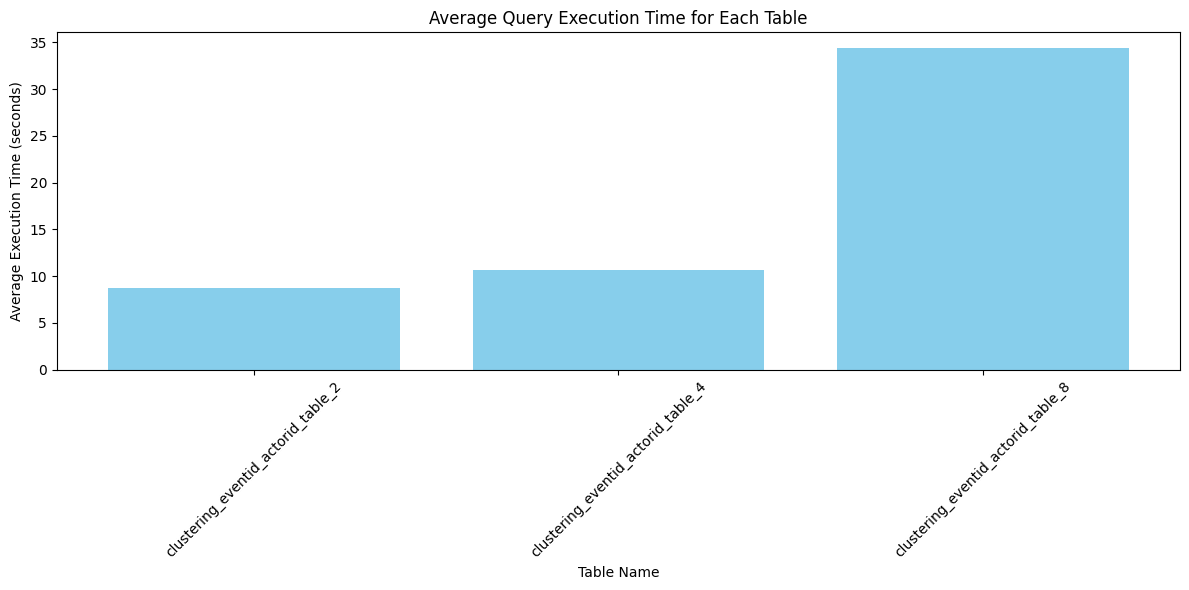

In [28]:
import time
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.types import StructType, StructField, StringType


tables = [
    'clustering_eventid_actorid_table_2',
    'clustering_eventid_actorid_table_4',
    'clustering_eventid_actorid_table_8'
]


num_executions = 5

def measure_execution_time(query):
    spark.catalog.clearCache()
    start_time = time.time()
    spark.sql(query).show() 
    end_time = time.time()
    return end_time - start_time

execution_times = {table: [] for table in tables}

for table in tables:
    for _ in range(num_executions):
        query = f"""
        SELECT
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country,
            SUM({table}.value) AS total_value,
            COUNT({table}.event_id) AS event_count
        FROM
            {table}
        JOIN
            product_dim ON {table}.product_id = product_dim.product_id
        JOIN
            location_dim ON {table}.location_id = location_dim.location_id
        WHERE
            {table}.event_id BETWEEN 459999 AND 999999  
            AND {table}.actor_id IN (5001, 5002, 5003)  
        GROUP BY
            product_dim.product_name,
            location_dim.city,
            location_dim.state,
            location_dim.country
        ORDER BY
            total_value DESC;"""
        
        try:
            execution_time = measure_execution_time(query)
            print(f"{table}: {execution_time} seconds")
            execution_times[table].append(execution_time)
        except Exception as e:
            print(f"Error for table {table}: {e}")

average_times = {table: sum(times) / num_executions for table, times in execution_times.items()}

df = pd.DataFrame(list(average_times.items()), columns=["Table", "Average Execution Time"])
print(df)

plt.figure(figsize=(12, 6))
plt.bar(df["Table"], df["Average Execution Time"], color='skyblue')
plt.xlabel('Table Name')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Average Query Execution Time for Each Table')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
average_times_query1_after = {
    'small_table  (2×10^9 rows)': 15.526392,
    'medium_table  (4×10^9 rows)': 15.484350,
    'big_table  (8×10^9 rows)': 35.589481
}
average_times_query1_before = {
    'small_table  (2×10^9 rows)': 227.679912,
    'medium_table  (4×10^9 rows)': 454.169286,
    'big_table  (8×10^9 rows)': 930.446069
}
average_times_query1_after = {
    'small_table\n($2\\times10^9$ rows)': 15.526392,
    'medium_table\n($4\\times10^9$ rows)': 15.484350,
    'big_table\n($8\\times10^9$ rows)': 35.589481
}

average_times_query1_before = {
    'small_table\n($2\\times10^9$ rows)': 227.679912,
    'medium_table\n($4\\times10^9$ rows)': 454.169286,
    'big_table\n($8\\times10^9$ rows)': 930.446069
}


In [15]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_comparison(before_times, after_times, query_num):
    plt.rcParams.update({'font.size': 14})  
    plt.rcParams.update({'axes.titlesize': 14}) 
    plt.rcParams.update({'axes.labelsize': 14})  
    plt.rcParams.update({'xtick.labelsize': 14})  
    plt.rcParams.update({'ytick.labelsize': 14}) 
    plt.rcParams.update({'legend.fontsize': 14})  
    plt.rcParams.update({'font.family': 'serif'})
    plt.rcParams.update({'font.serif': 'DejaVu Serif'})

    df_before = pd.DataFrame(list(before_times.items()), columns=["Table", "Average Execution Time Before Clustering"])
    df_after = pd.DataFrame(list(after_times.items()), columns=["Table", "Average Execution Time After Clustering"])
    df = df_before.merge(df_after, on="Table")

    ax = df.plot(kind="bar", x="Table", figsize=(12, 6))
    plt.ylabel('Average Execution Time (seconds)')
    plt.xlabel('')
    plt.title(f'Average Query Execution Time for Each Table (Query 1, Z-Order column {query_num})')
    plt.xticks(rotation=0)
    
    plt.ylim(0, 1100)
    legend = ax.legend(loc='upper left', bbox_to_anchor=(0, 1), prop={'size': 12}) 

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.2f}', 
                    (p.get_x() + p.get_width() / 2., height * 1.01),  
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(f'clustering_table_performance_{query_num}.png', dpi=500)
    plt.show()

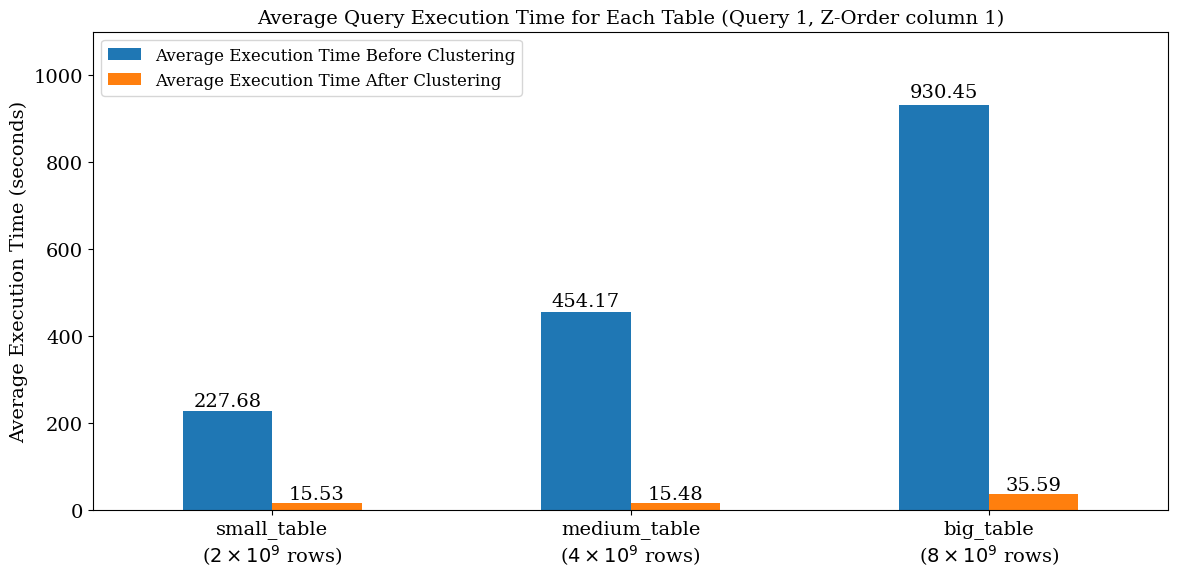

In [16]:
plot_comparison(average_times_query1_before, average_times_query1_after, 1)

In [25]:
json_file_path = "/datalake/liquidclustering/clustering_eventid_actorid_table_2/_delta_log/00000000000000000002.json"
df = spark.read.json(json_file_path)
df.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+
|add                                                                                                              

In [26]:
spark.sql("""describe detail clustering_eventid_actorid_table_2""").show()

+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------------------+--------+------------+----------+----------------+----------------+--------------------+
|format|                  id|                name|description|            location|           createdAt|        lastModified|partitionColumns|   clusteringColumns|numFiles| sizeInBytes|properties|minReaderVersion|minWriterVersion|       tableFeatures|
+------+--------------------+--------------------+-----------+--------------------+--------------------+--------------------+----------------+--------------------+--------+------------+----------+----------------+----------------+--------------------+
| delta|be1d3676-2650-44a...|spark_catalog.liq...|       NULL|hdfs://192.168.0....|2024-07-17 17:22:...|2024-07-18 10:30:...|              []|[event_id, actor_id]|     226|253057136986|        {}|               1|               7|[clustering, d

In [11]:
from pyspark.sql import SparkSession
import json


delta_table_path = "hdfs://192.168.0.144:9000/datalake/liquidclustering/liquidclustering_optimized/"

log_path = f"{delta_table_path}/_delta_log"
log_files = spark.read.format("text").load(log_path)

log_data = log_files.rdd.map(lambda row: row.value).collect()

chunk_size = 10 s

for i in range(0, len(log_data), chunk_size):
    chunk = log_data[i:i+chunk_size]
    for log_entry in chunk:
        log_json = json.loads(log_entry)
        print(json.dumps(log_json, indent=4))
    input("Press Enter to continue...") 


24/06/15 23:39:07 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.
24/06/15 23:39:07 WARN DataSource: All paths were ignored:
  hdfs://192.168.0.144:9000/datalake/liquidclustering/liquidclustering_optimized/_delta_log


{
    "commitInfo": {
        "timestamp": 1718494417882,
        "operation": "WRITE",
        "operationParameters": {
            "mode": "Append",
            "partitionBy": "[]"
        },
        "readVersion": 0,
        "isolationLevel": "Serializable",
        "isBlindAppend": true,
        "operationMetrics": {
            "numFiles": "20",
            "numOutputRows": "1000000000",
            "numOutputBytes": "23165992194"
        },
        "engineInfo": "Apache-Spark/3.5.1 Delta-Lake/3.1.0",
        "txnId": "3d62e95b-1622-4741-bfcb-efca072ddb42"
    }
}
{
    "add": {
        "path": "part-00000-a8749ac9-6ee0-4a21-be6f-bf8d6dd72274-c000.snappy.parquet",
        "partitionValues": {},
        "size": 1158298842,
        "modificationTime": 1718494415828,
        "dataChange": true,
        "stats": "{\"numRecords\":50000000,\"minValues\":{\"date\":\"2024-01-01\",\"timestamp\":\"2024-01-01T00:00:00.000Z\",\"value\":4.800579933572635E-9,\"country\":\"Afghanistan\",\"event_

Press Enter to continue... 


{
    "add": {
        "path": "part-00009-19a95f4a-bed0-457a-9196-14be459fee6e-c000.snappy.parquet",
        "partitionValues": {},
        "size": 1158298306,
        "modificationTime": 1718494383917,
        "dataChange": true,
        "stats": "{\"numRecords\":50000000,\"minValues\":{\"date\":\"2024-01-01\",\"timestamp\":\"2038-04-05T08:00:00.000Z\",\"value\":1.414320827120008E-8,\"country\":\"Afghanistan\",\"event_id\":0,\"actor_id\":0},\"maxValues\":{\"date\":\"2024-01-01\",\"timestamp\":\"2039-11-05T00:53:19.000Z\",\"value\":0.9999999863151596,\"country\":\"Yemen\",\"event_id\":999999,\"actor_id\":999999},\"nullCount\":{\"date\":0,\"timestamp\":0,\"value\":0,\"country\":0,\"event_id\":0,\"actor_id\":0}}"
    }
}
{
    "add": {
        "path": "part-00010-8ada0df3-193e-4e03-abe2-aa6d76a8c39b-c000.snappy.parquet",
        "partitionValues": {},
        "size": 1158299617,
        "modificationTime": 1718494411535,
        "dataChange": true,
        "stats": "{\"numRecords\":5000

Press Enter to continue... 


{
    "add": {
        "path": "part-00019-41f5df41-0663-400c-b7d4-2cbc2c676ecb-c000.snappy.parquet",
        "partitionValues": {},
        "size": 1158299332,
        "modificationTime": 1718494410247,
        "dataChange": true,
        "stats": "{\"numRecords\":50000000,\"minValues\":{\"date\":\"2024-01-01\",\"timestamp\":\"2054-02-07T08:53:20.000Z\",\"value\":4.18056432804903E-8,\"country\":\"Afghanistan\",\"event_id\":0,\"actor_id\":0},\"maxValues\":{\"date\":\"2024-01-01\",\"timestamp\":\"2055-09-09T01:46:39.000Z\",\"value\":0.9999999624718395,\"country\":\"Yemen\",\"event_id\":999999,\"actor_id\":999999},\"nullCount\":{\"date\":0,\"timestamp\":0,\"value\":0,\"country\":0,\"event_id\":0,\"actor_id\":0}}"
    }
}
{
    "commitInfo": {
        "timestamp": 1718493370909,
        "operation": "CREATE TABLE",
        "operationParameters": {
            "isManaged": "true",
            "description": null,
            "partitionBy": "[]",
            "properties": "{}"
        },
  

Press Enter to continue... 


In [18]:
!hdfs dfs -cat /datalake/liquidclustering/liquidclustering_optimized/_delta_log/00000000000000000000.json

{"commitInfo":{"timestamp":1718489037000,"operation":"CREATE TABLE","operationParameters":{"isManaged":"true","description":null,"partitionBy":"[]","properties":"{}"},"isolationLevel":"Serializable","isBlindAppend":true,"operationMetrics":{},"engineInfo":"Apache-Spark/3.5.1 Delta-Lake/3.1.0","txnId":"8ff00c39-77e3-41d9-a449-9993c5a6d97e"}}
{"metaData":{"id":"1bab68ea-57c0-4a15-adbd-e5ca81d2f0b4","format":{"provider":"parquet","options":{}},"schemaString":"{\"type\":\"struct\",\"fields\":[{\"name\":\"date\",\"type\":\"date\",\"nullable\":true,\"metadata\":{}},{\"name\":\"timestamp\",\"type\":\"timestamp\",\"nullable\":true,\"metadata\":{}},{\"name\":\"value\",\"type\":\"double\",\"nullable\":true,\"metadata\":{}},{\"name\":\"country\",\"type\":\"string\",\"nullable\":true,\"metadata\":{}},{\"name\":\"event_id\",\"type\":\"integer\",\"nullable\":true,\"metadata\":{}},{\"name\":\"actor_id\",\"type\":\"integer\",\"nullable\":true,\"metadata\":{}}]}","partitionColumns":[],"configuration":{}

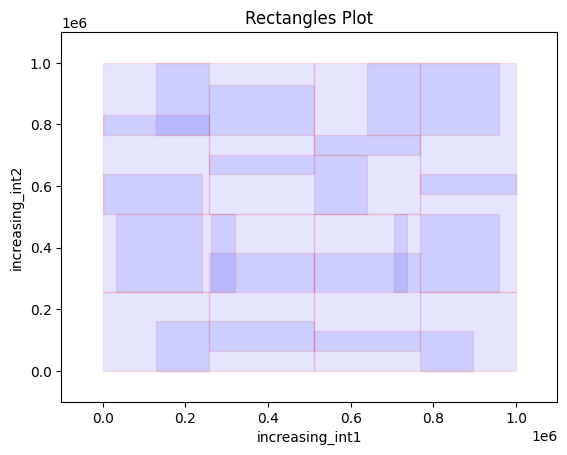

In [16]:
import json
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import Row



file_path = "hdfs://192.168.0.144:9000/datalake/liquidclustering/liquidclustering_optimized/_delta_log/00000000000000000002.json"

df = spark.read.text(file_path)

rows = []

for row in df.collect():
    json_obj = json.loads(row.value)
    if 'add' in json_obj and 'stats' in json_obj['add']:
        path = json_obj['add']['path']
        stats = json.loads(json_obj['add']['stats'])
        min_increasing_int1 = stats['minValues']['event_id']
        max_increasing_int1 = stats['maxValues']['event_id']
        min_increasing_int2 = stats['minValues']['actor_id']
        max_increasing_int2 = stats['maxValues']['actor_id']
        
        rows.append(Row(path=path, 
                        min_increasing_int1=min_increasing_int1, 
                        max_increasing_int1=max_increasing_int1,
                        min_increasing_int2=min_increasing_int2,
                        max_increasing_int2=max_increasing_int2))

result_df = spark.createDataFrame(rows)

rectangles = result_df.collect()

fig, ax = plt.subplots()

for rect in rectangles:
    bottom_left_x = rect.min_increasing_int1
    bottom_left_y = rect.min_increasing_int2
    top_right_x = rect.max_increasing_int1
    top_right_y = rect.max_increasing_int2

    width = top_right_x - bottom_left_x
    height = top_right_y - bottom_left_y

    rectangle = plt.Rectangle((bottom_left_x, bottom_left_y), width, height, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.1)

    ax.add_patch(rectangle)

all_x = [rect.min_increasing_int1 for rect in rectangles] + [rect.max_increasing_int1 for rect in rectangles]
all_y = [rect.min_increasing_int2 for rect in rectangles] + [rect.max_increasing_int2 for rect in rectangles]
padding_x = (max(all_x) - min(all_x)) * 0.1
padding_y = (max(all_y) - min(all_y)) * 0.1
ax.set_xlim(min(all_x) - padding_x, max(all_x) + padding_x)
ax.set_ylim(min(all_y) - padding_y, max(all_y) + padding_y)

ax.set_xlabel('increasing_int1')
ax.set_ylabel('increasing_int2')
ax.set_title('Rectangles Plot')

plt.show()
